In [1]:
import QuantLib as ql
import pandas as pd
from datetime import datetime
from IPython.display import display, HTML
import matplotlib.pyplot as plt

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import pandas as pd
import os

import requests
from bs4 import BeautifulSoup
import pandas as pd
import re

from scipy.interpolate import PchipInterpolator
from ipywidgets import interact, widgets

display(HTML("<style>.container { width:95% !important; }</style>"))
#126.0.6478.63
chrome_driver_path = r"C:\Program Files\chromedriver\chromedriver.exe"

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re

# URL of the webpage
url = 'https://uk.investing.com/rates-bonds/uk-government-bonds'

# Headers to mimic a real browser visit
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

# Send a GET request
response = requests.get(url, headers=headers)

# Parse the HTML content
soup = BeautifulSoup(response.content, 'html.parser')

# Attempt to find the table containing bond data
table = soup.find('table')

# If the table is not found, log the page content and try to find all tables
if table is None:
    print("Table not found. Printing full page content for inspection:")
    print(soup.prettify())  # Print the full HTML content for manual inspection
    raise ValueError("Correct table not found. Please check the HTML structure of the page.")

# Extract table headers
headers = [header.text.strip() for header in table.find_all('th')]
#print("Extracted headers:", headers)

# Extract bond data
bond_data = []
for row in table.find_all('tr')[1:]:  # Skip the header row
    columns = row.find_all('td')
    if len(columns) >= 7:  # Ensure there are enough columns
        bond_data.append([col.text.strip() for col in columns[:7]])  # Extract relevant columns

# Create a DataFrame
df = pd.DataFrame(bond_data, columns=headers[:7])

# Convert bond names to numeric maturities
def get_maturity_years(bond_name):
    match = re.search(r'U\.K\. (\d+)([MY])', bond_name)
    if match:
        value = int(match.group(1))
        unit = match.group(2)
        if unit == 'M':
            return value / 12  # Convert months to years
        elif unit == 'Y':
            return value  # Years are already in the correct unit
    return None

# Ensure the column name matches exactly
bond_name_column = 'Name' if 'Name' in df.columns else df.columns[0]
df["Maturity (Years)"] = df[bond_name_column].apply(get_maturity_years)

df = df.drop(columns=['High', 'Low', 'Chg.'])
df = df[['Name', 'Maturity (Years)', 'Yield', 'Prev.']]
df = df.rename(columns={'Maturity (Years)': 'Tenor','Prev.': 'Prev'})
df['Tenor'] = pd.to_numeric(df['Tenor'])
df['Yield'] = pd.to_numeric(df['Yield'])
df['Prev'] = pd.to_numeric(df['Prev'])
# Display the DataFrame
print(df)

        Name      Tenor   Yield   Prev
0    U.K. 1M   0.083333  5.3890  5.311
1    U.K. 3M   0.250000  5.3010  5.242
2    U.K. 6M   0.500000  5.2050  5.187
3    U.K. 1Y   1.000000  4.6650  4.645
4    U.K. 2Y   2.000000  4.1940  4.179
5    U.K. 3Y   3.000000  4.0575  4.037
6    U.K. 4Y   4.000000  4.1135  4.090
7    U.K. 5Y   5.000000  3.9555  3.937
8    U.K. 6Y   6.000000  3.9105  3.891
9    U.K. 7Y   7.000000  3.9535  3.931
10   U.K. 8Y   8.000000  3.9785  3.953
11   U.K. 9Y   9.000000  4.0590  4.033
12  U.K. 10Y  10.000000  4.1030  4.081
13  U.K. 12Y  12.000000  4.2280  4.191
14  U.K. 15Y  15.000000  4.4030  4.367
15  U.K. 20Y  20.000000  4.5760  4.538
16  U.K. 25Y  25.000000  4.5910  4.554
17  U.K. 30Y  30.000000  4.6310  4.590
18  U.K. 40Y  40.000000  4.5590  4.521
19  U.K. 50Y  50.000000  4.1800  4.150


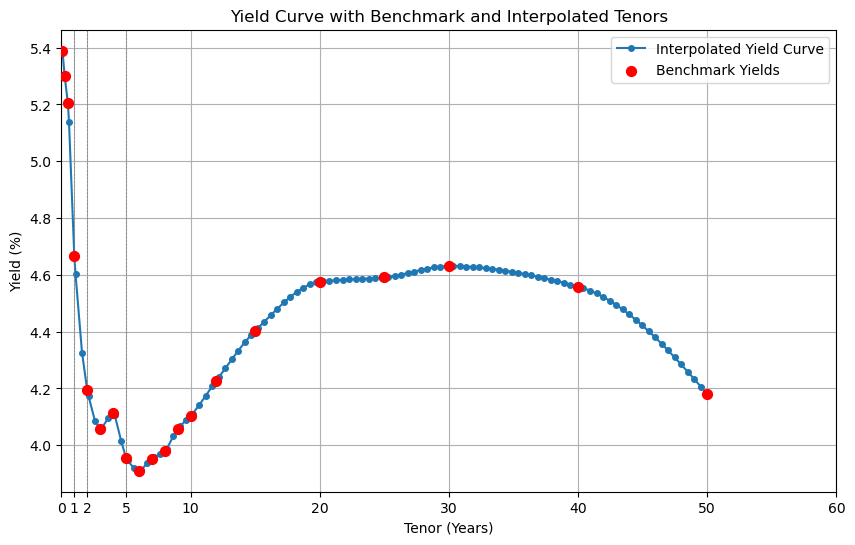

        Tenor     Yield
0    0.083333  5.389000
1    0.250000  5.301000
2    0.500000  5.205000
1    0.587542  5.137751
3    1.000000  4.665000
..        ...       ...
96  48.487374  4.259064
97  48.991582  4.233093
98  49.495791  4.206711
19  50.000000  4.180000
99  50.000000  4.180000

[119 rows x 2 columns]


In [3]:
import pandas as pd
from scipy.interpolate import PchipInterpolator
import numpy as np
from ipywidgets import interact, widgets

# Create the Hermite spline interpolator (PCHIP)
interpolator = PchipInterpolator(df['Tenor'], df['Yield'])

# Generate a range of tenors for interpolation
tenors_interpolated = np.linspace(df['Tenor'].min(), df['Tenor'].max(), 100)
yields_interpolated = interpolator(tenors_interpolated)

# Create a new DataFrame with interpolated data
df_interpolated = pd.DataFrame({
    'Tenor': tenors_interpolated,
    'Yield': yields_interpolated
})

# Combine the benchmark and interpolated data
df_combined = pd.concat([df[['Tenor', 'Yield']], df_interpolated]).drop_duplicates().sort_values(by='Tenor')

# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(df_combined['Tenor'], df_combined['Yield'], label='Interpolated Yield Curve', linestyle='-', marker='o', markersize=4)
plt.scatter(df['Tenor'], df['Yield'], color='red', label='Benchmark Yields', zorder=5, s=50)

# Customize x-axis ticks and add vertical gridlines at specific points
plt.xticks(list(plt.xticks()[0]) + [1, 2, 5])
plt.axvline(x=1, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(x=2, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(x=5, color='gray', linestyle='--', linewidth=0.5)

# Set the x-axis to start from 0
plt.xlim(0, df['Tenor'].max() + 10)

plt.xlabel('Tenor (Years)')
plt.ylabel('Yield (%)')
plt.title('Yield Curve with Benchmark and Interpolated Tenors')
plt.legend()
plt.grid(True)
plt.show()

# Display the combined DataFrame
print(df_combined)

In [4]:
# Function to plot interpolated curve with selected bond names
def plot_yield_curve(selected_names):
    selected_df = df[df['Name'].isin(selected_names)]
    
    # Create the Hermite spline interpolator (PCHIP)
    interpolator = PchipInterpolator(selected_df['Tenor'], selected_df['Yield'])
    
    # Generate a range of tenors for interpolation
    tenors_interpolated = np.linspace(selected_df['Tenor'].min(), selected_df['Tenor'].max(), 100)
    yields_interpolated = interpolator(tenors_interpolated)
    
    # Create a new DataFrame with interpolated data
    df_interpolated = pd.DataFrame({
        'Tenor': tenors_interpolated,
        'Yield': yields_interpolated
    })
    
    # Combine the benchmark and interpolated data
    df_combined = pd.concat([selected_df[['Tenor', 'Yield']], df_interpolated]).drop_duplicates().sort_values(by='Tenor')
    
    # Plot the graph
    plt.figure(figsize=(10, 6))
    plt.plot(df_combined['Tenor'], df_combined['Yield'], label='Interpolated Yield Curve', linestyle='-', marker='o', markersize=4)
    plt.scatter(df['Tenor'], df['Yield'], color='red', label='Benchmark Yields', zorder=5, s=50)
    
    # Customize x-axis ticks and add vertical gridlines at specific points
    plt.xticks(list(plt.xticks()[0]) + [1, 2, 5])
    plt.axvline(x=1, color='gray', linestyle='--', linewidth=0.5)
    plt.axvline(x=2, color='gray', linestyle='--', linewidth=0.5)
    plt.axvline(x=5, color='gray', linestyle='--', linewidth=0.5)
    
    # Set the x-axis to start from 0
    plt.xlim(0, df['Tenor'].max() + 10)
    
    plt.xlabel('Tenor (Years)')
    plt.ylabel('Yield (%)')
    plt.title('Yield Curve with Benchmark and Interpolated Tenors (curve built without outliers)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Interactive widget to select bond names
name_selector = widgets.SelectMultiple(
    options=list(df['Name']),
    value=['U.K. 1M', 'U.K. 3M', 'U.K. 6M', 'U.K. 1Y', 'U.K. 2Y', 'U.K. 3Y', 'U.K. 5Y', 'U.K. 6Y', 'U.K. 7Y', 'U.K. 8Y', 'U.K. 9Y', 'U.K. 10Y', 'U.K. 12Y', 'U.K. 15Y', 'U.K. 20Y', 'U.K. 30Y', 'U.K. 40Y', 'U.K. 50Y'],
    description='Bond Names',
    disabled=False
)

# Create an interactive plot
interact(plot_yield_curve, selected_names=name_selector)


interactive(children=(SelectMultiple(description='Bond Names', index=(0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 1…

<function __main__.plot_yield_curve(selected_names)>

In [5]:
# Function to plot interpolated curve with selected bond names
def plot_yield_curve(selected_names):
    selected_df = df[df['Name'].isin(selected_names)]
    
    # Create the Hermite spline interpolator (PCHIP)
    interpolator = PchipInterpolator(selected_df['Tenor'], selected_df['Yield'])
    
    # Generate a range of tenors for interpolation
    tenors_interpolated = np.linspace(selected_df['Tenor'].min(), selected_df['Tenor'].max(), 100)
    yields_interpolated = interpolator(tenors_interpolated)
    
    # Create a new DataFrame with interpolated data
    df_interpolated = pd.DataFrame({
        'Tenor': tenors_interpolated,
        'Yield': yields_interpolated
    })
    
    # Combine the benchmark and interpolated data
    df_combined = pd.concat([selected_df[['Tenor', 'Yield']], df_interpolated]).drop_duplicates().sort_values(by='Tenor')
    
    # Plot the graph
    plt.figure(figsize=(10, 6))
    plt.plot(df_combined['Tenor'], df_combined['Yield'], label='Interpolated Yield Curve', linestyle='-', marker='o', markersize=4)
    plt.scatter(df['Tenor'], df['Yield'], color='red', label='Benchmark Yields', zorder=5, s=50)
    
    # Customize x-axis ticks and add vertical gridlines at specific points
    plt.xticks(list(plt.xticks()[0]) + [1, 2, 5])
    plt.axvline(x=1, color='gray', linestyle='--', linewidth=0.5)
    plt.axvline(x=2, color='gray', linestyle='--', linewidth=0.5)
    plt.axvline(x=5, color='gray', linestyle='--', linewidth=0.5)
    
    # Set the x-axis to start from 0
    plt.xlim(0, df['Tenor'].max() + 10)
    
    plt.xlabel('Tenor (Years)')
    plt.ylabel('Yield (%)')
    plt.title('Yield Curve with Benchmark and Interpolated Tenors (curve built without outliers)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Interactive widget to select bond names
name_selector = widgets.SelectMultiple(
    options=list(df['Name']),
    value=['U.K. 1M', 'U.K. 3M', 'U.K. 6M', 'U.K. 1Y', 'U.K. 2Y', 'U.K. 3Y', 'U.K. 5Y', 'U.K. 6Y', 'U.K. 7Y', 'U.K. 8Y', 'U.K. 9Y', 'U.K. 10Y', 'U.K. 12Y', 'U.K. 15Y', 'U.K. 20Y', 'U.K. 30Y', 'U.K. 40Y', 'U.K. 50Y'],
    description='Bond Names',
    disabled=False
)

# Create an interactive plot
interact(plot_yield_curve, selected_names=name_selector)


interactive(children=(SelectMultiple(description='Bond Names', index=(0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 1…

<function __main__.plot_yield_curve(selected_names)>